<a href="https://colab.research.google.com/github/anudaindu/CM2604_Telco_Churn_Anuda/blob/main/DiabetesRiskPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# ============================================
# 1. SETUP AND DATA LOADING
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve, auc, log_loss
)
import warnings
warnings.filterwarnings('ignore')

# Import all required models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
file_path = '/content/drive/MyDrive/YourFolder/balanced_diabetes_data.csv'
df = pd.read_csv(file_path)

In [11]:


print("="*60)
print("1. DATA LOADING COMPLETE")
print("="*60)
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

1. DATA LOADING COMPLETE
Dataset shape: (1761, 14)

First 5 rows:
   user_id        date     weight      height  blood_glucose  \
0      595  2022-10-13  85.563099  150.000000     173.937235   
1      275  2021-10-28  55.277370  182.130977      96.510162   
2      854  2023-07-24  87.835248  179.191542     148.821657   
3      157  2021-06-20  97.986618  163.118496     124.992145   
4      663  2022-12-26  69.508701  150.000000     163.889129   

   physical_activity  diet  medication_adherence  stress_level  sleep_hours  \
0          55.184665     1                     1             2     9.268495   
1          11.674518     0                     0             2    10.361847   
2           7.856864     1                     0             2     5.025379   
3           5.251467     0                     1             0     6.398124   
4          37.466971     1                     0             1     6.932074   

   hydration_level   bmi  risk_score risk_level  
0                1  38.0

In [12]:

# ============================================
# 2. DATA CLEANING
# ============================================
print("\n" + "="*60)
print("2. DATA CLEANING")
print("="*60)

# Remove duplicates
df = df.drop_duplicates()

# Clean unrealistic values
df = df[(df['weight'] > 30) & (df['weight'] < 200)]
df = df[(df['height'] > 100) & (df['height'] < 250)]
df = df[(df['bmi'] > 10) & (df['bmi'] < 60)]
df = df[(df['blood_glucose'] >= 70) & (df['blood_glucose'] <= 300)]
df = df[(df['sleep_hours'] >= 0) & (df['sleep_hours'] <= 24)]

print(f"Shape after cleaning: {df.shape}")

# Check correlation between features
print("\n" + "-"*40)
print("CORRELATION ANALYSIS")
print("-"*40)
# Check correlation between weight, height, and BMI
correlation_check = df[['weight', 'height', 'bmi']].corr()
print("Correlation between weight, height, and BMI:")
print(correlation_check)


2. DATA CLEANING
Shape after cleaning: (713, 14)

----------------------------------------
CORRELATION ANALYSIS
----------------------------------------
Correlation between weight, height, and BMI:
          weight    height       bmi
weight  1.000000 -0.048747  0.875669
height -0.048747  1.000000 -0.512119
bmi     0.875669 -0.512119  1.000000


Explotary Data Analysis

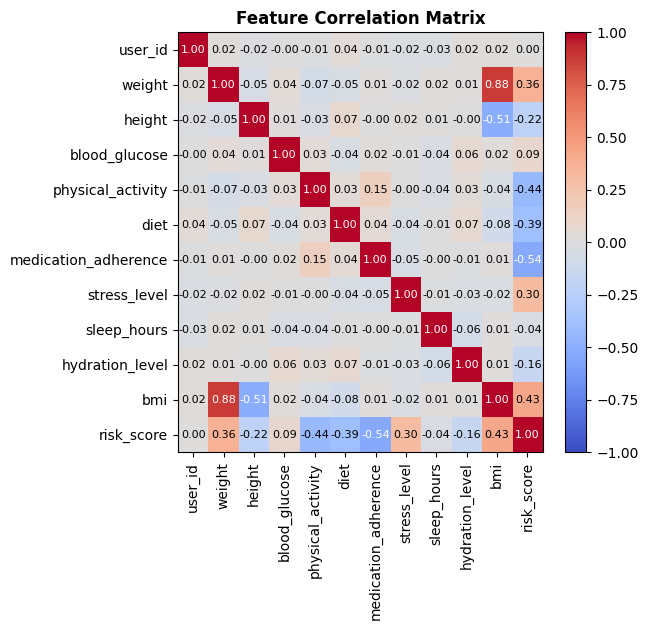

In [13]:
# Create figure for EDA plots
plt.figure(figsize=(20, 12))
# 1. Correlation heatmap for all numerical features
plt.subplot(2, 3, 1)
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im)
plt.title('Feature Correlation Matrix', fontsize=12, fontweight='bold')
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)

# Add correlation values
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        text = plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="white" if abs(correlation_matrix.iloc[i, j]) > 0.5 else "black",
                       fontsize=8)

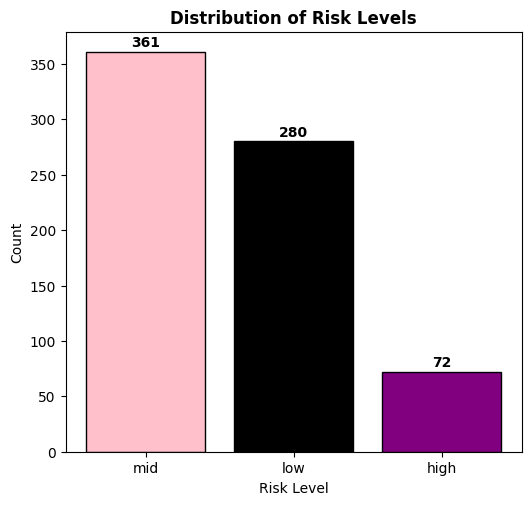

In [14]:
# Create figure for EDA plots
plt.figure(figsize=(20, 12))
# 2. Target variable distribution
plt.subplot(2, 3, 2)
risk_counts = df['risk_level'].value_counts()
risk_labels = risk_counts.index
risk_values = risk_counts.values
colors = ['pink', 'black', 'purple']
bars = plt.bar(risk_labels, risk_values, color=colors, edgecolor='black')
plt.title('Distribution of Risk Levels', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Count')
for i, v in enumerate(risk_values):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')

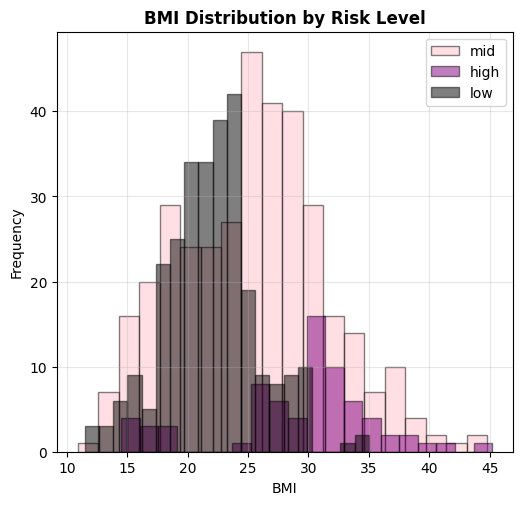

In [15]:
# Create figure for EDA plots
plt.figure(figsize=(20, 12))
# 3. BMI distribution by risk level
plt.subplot(2, 3, 3)
risk_levels = df['risk_level'].unique()
for risk in risk_levels:
    subset = df[df['risk_level'] == risk]
    if risk == 'low':
        color = 'black'
    elif risk == 'mid':
        color = 'pink'
    else:
        color = 'purple'
    plt.hist(subset['bmi'], alpha=0.5, label=risk, color=color, bins=20, edgecolor='black')
plt.title('BMI Distribution by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)


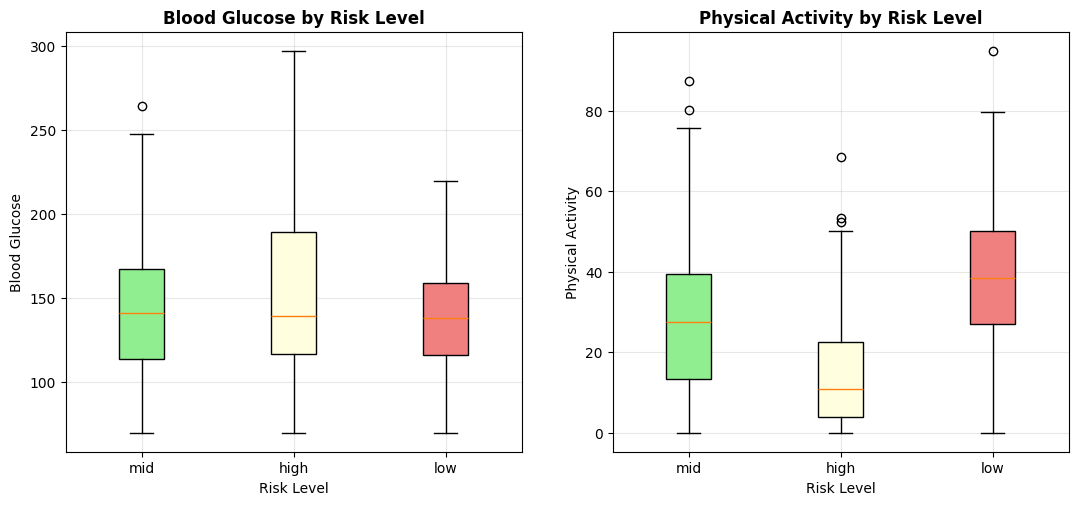

In [16]:
# Create figure for EDA plots
plt.figure(figsize=(20, 12))

# 4. Blood glucose by risk level
plt.subplot(2, 3, 4)
box_data = [df[df['risk_level'] == risk]['blood_glucose'].values for risk in risk_levels]
bp = plt.boxplot(box_data, labels=risk_levels, patch_artist=True)
colors_box = ['lightgreen', 'lightyellow', 'lightcoral']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
plt.title('Blood Glucose by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Blood Glucose')
plt.grid(True, alpha=0.3)

# 5. Physical activity by risk level
plt.subplot(2, 3, 5)
box_data = [df[df['risk_level'] == risk]['physical_activity'].values for risk in risk_levels]
bp = plt.boxplot(box_data, labels=risk_levels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
plt.title('Physical Activity by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Physical Activity')
plt.grid(True, alpha=0.3)



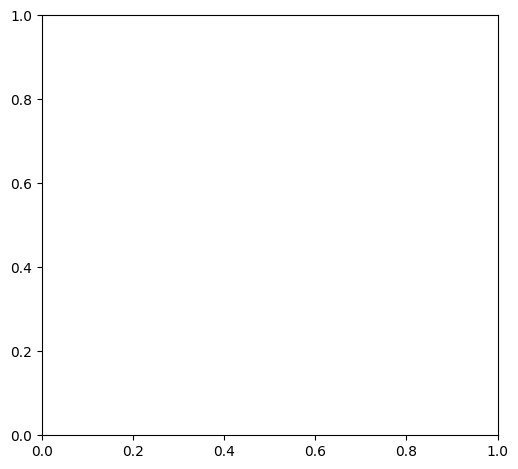

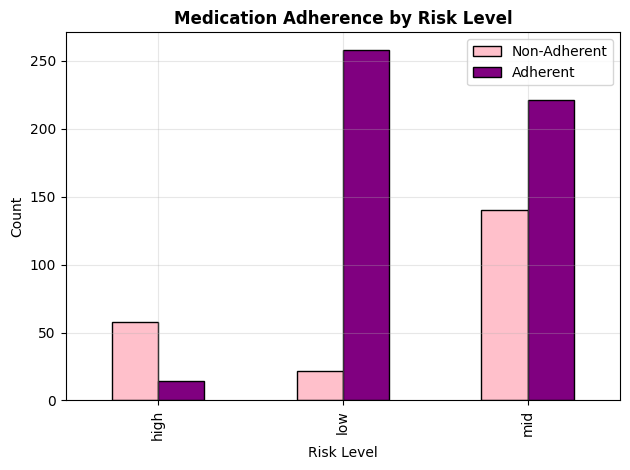

In [17]:
# Create figure for EDA plots
plt.figure(figsize=(20, 12))
# 6. Medication adherence by risk level
plt.subplot(2, 3, 6)
medication_by_risk = df.groupby('risk_level')['medication_adherence'].value_counts().unstack()
medication_by_risk.plot(kind='bar', color=['pink', 'purple'], edgecolor='black')
plt.title('Medication Adherence by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.legend(['Non-Adherent', 'Adherent'])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# ============================================
# 3. PREPROCESSING WITH BALANCING (CORRECTED)
# ============================================
print("\n" + "="*60)
print("3. DATA PREPROCESSING WITH BALANCING")
print("="*60)

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Drop unnecessary columns and separate target
df_processed = df.drop(columns=['user_id', 'date', 'weight', 'height', 'risk_score'])

# Define features (X) and target (y)
X = df_processed.drop(columns=['risk_level'])
y = df_processed['risk_level']

# Convert to binary target
y = y.apply(lambda x: 1 if x == 'high' else 0)

# Train-test split FIRST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n✓ Train-test split done.")
print("Training set class distribution:")
print(y_train.value_counts())
print("\nTest set class distribution:")
print(y_test.value_counts())

# Scale AFTER splitting (fit only on train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE ONLY on training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(
    X_train_scaled, y_train
)

print("\n✓ SMOTE applied ONLY on training data")

print("\nAfter SMOTE (Training set):")
print(pd.Series(y_train_balanced).value_counts())

# Final sets for modeling
X_train_final = X_train_balanced
y_train_final = y_train_balanced

X_test_final = X_test_scaled
y_test_final = y_test

print("\n✓ Data preprocessing pipeline is now CORRECT and SAFE from leakage")



3. DATA PREPROCESSING WITH BALANCING

✓ Train-test split done.
Training set class distribution:
risk_level
0    512
1     58
Name: count, dtype: int64

Test set class distribution:
risk_level
0    129
1     14
Name: count, dtype: int64

✓ SMOTE applied ONLY on training data

After SMOTE (Training set):
risk_level
0    512
1    512
Name: count, dtype: int64

✓ Data preprocessing pipeline is now CORRECT and SAFE from leakage


In [19]:
print("\n" + "="*60)
print("5. MODEL TRAINING - BASE MODELS + ENSEMBLES + ANN")
print("="*60)

from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    StackingClassifier
)

# -------------------------------
# Base ANN Model
# -------------------------------
ann_base = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

# ============================
# Model Definitions
# ============================

models = {

    # ============================
    # Base Models
    # ============================
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'ANN': ann_base,

    # ============================
    # Bagging Models
    # ============================
    'Random Forest': RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=10
    ),

    'Bagging (ANN)': BaggingClassifier(
        estimator=MLPClassifier(
            hidden_layer_sizes=(32,),
            max_iter=300,
            random_state=42
        ),
        n_estimators=10,
        random_state=42
    ),

    # ============================
    # Boosting Models
    # ============================
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=42,
        n_estimators=100
    ),

    'AdaBoost (ANN)': AdaBoostClassifier(
        estimator=MLPClassifier(
            hidden_layer_sizes=(16,),
            max_iter=200,
            random_state=42
        ),
        n_estimators=10,
        learning_rate=0.5,
        random_state=42
    ),

    'XGBoost': XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42,
        verbosity=0
    )
}

# ============================
# Stacking (ANN as Meta-Learner)
# ============================

stacking_model = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('svm', SVC(probability=True, random_state=42))
    ],
    final_estimator=MLPClassifier(
        hidden_layer_sizes=(32, 16),
        max_iter=500,
        random_state=42
    ),
    passthrough=True
)

models['Stacking (ANN Meta-Learner)'] = stacking_model

# ==============
# Training Loop
# ==============

trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    try:
        if name == 'XGBoost':
            model.fit(
                X_train_final, y_train_final,
                eval_set=[(X_test_final, y_test)],
                verbose=False
            )
        else:
            model.fit(X_train_final, y_train_final)

        trained_models[name] = model

        train_acc = model.score(X_train_final, y_train_final)
        print(f"  ✓ {name} trained | Train Accuracy: {train_acc:.4f}")

    except Exception as e:
        print(f"  ✗ Error training {name}: {str(e)}")

print("\n" + "="*60)
print("MODEL TRAINING COMPLETE")
print("="*60)
print(f"✓ Total models trained: {len(trained_models)}")



5. MODEL TRAINING - BASE MODELS + ENSEMBLES + ANN

Training Logistic Regression...
  ✓ Logistic Regression trained | Train Accuracy: 0.9521

Training Decision Tree...
  ✓ Decision Tree trained | Train Accuracy: 0.9688

Training SVM...
  ✓ SVM trained | Train Accuracy: 0.9795

Training KNN...
  ✓ KNN trained | Train Accuracy: 0.9668

Training Naive Bayes...
  ✓ Naive Bayes trained | Train Accuracy: 0.9229

Training ANN...
  ✓ ANN trained | Train Accuracy: 0.9131

Training Random Forest...
  ✓ Random Forest trained | Train Accuracy: 1.0000

Training Bagging (ANN)...
  ✓ Bagging (ANN) trained | Train Accuracy: 0.9756

Training Gradient Boosting...
  ✓ Gradient Boosting trained | Train Accuracy: 1.0000

Training AdaBoost (ANN)...
  ✗ Error training AdaBoost (ANN): MLPClassifier doesn't support sample_weight.

Training XGBoost...
  ✓ XGBoost trained | Train Accuracy: 1.0000

Training Stacking (ANN Meta-Learner)...
  ✓ Stacking (ANN Meta-Learner) trained | Train Accuracy: 1.0000

MODEL TRAI


6. FINAL MODEL EVALUATION

Evaluating Logistic Regression...
✓ Logistic Regression            | Accuracy: 0.9510 | Recall: 0.8571 | F1: 0.7742

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.98      0.96      0.97       129
   High Risk       0.71      0.86      0.77        14

    accuracy                           0.95       143
   macro avg       0.85      0.91      0.87       143
weighted avg       0.96      0.95      0.95       143

------------------------------------------------------------

Evaluating Decision Tree...
✓ Decision Tree                  | Accuracy: 0.9510 | Recall: 0.7857 | F1: 0.7586

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.98      0.97      0.97       129
   High Risk       0.73      0.79      0.76        14

    accuracy                           0.95       143
   macro avg       0.85      0.88      0.87       143
weighted avg       0.95      0.95    

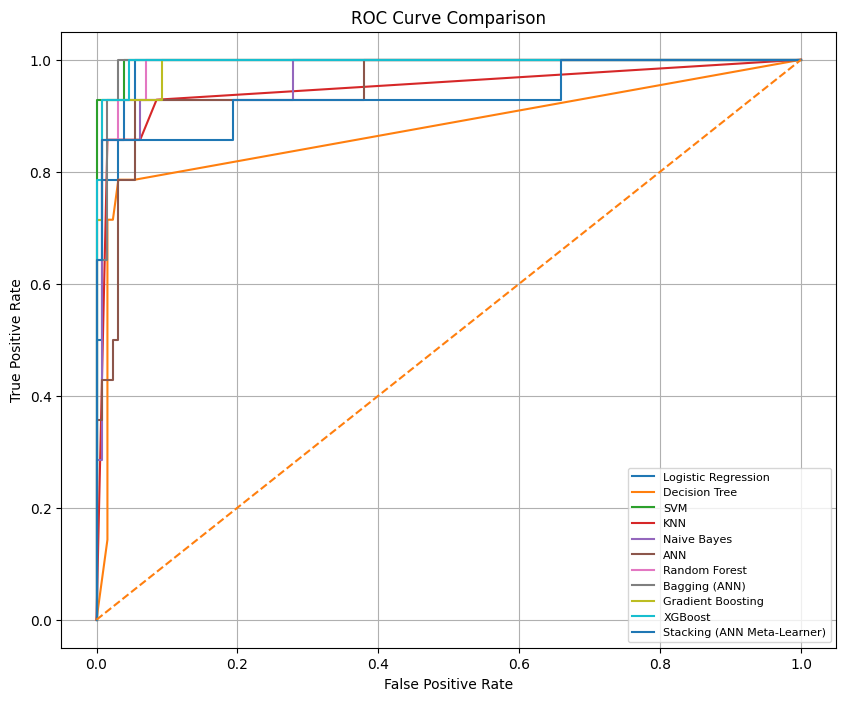

In [20]:
print("\n" + "="*60)
print("6. FINAL MODEL EVALUATION")
print("="*60)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)

# -------------------------------
# Evaluation Function
# -------------------------------

def evaluate_model(model, X_test, y_test, model_name):
    try:
        y_pred = model.predict(X_test)

        # Probabilities for ROC-AUC
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_pred_proba = model.decision_function(X_test)
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / \
                            (y_pred_proba.max() - y_pred_proba.min())
        else:
            y_pred_proba = None

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

        # Model type detection (ANN treated as Base)
        ensemble_keywords = ['Random Forest', 'Bagging', 'Gradient Boosting',
                            'AdaBoost', 'XGBoost', 'Stacking', 'Ensemble']

        if any(keyword in model_name for keyword in ensemble_keywords):
            model_type = 'Ensemble'
        else:
            model_type = 'Base'

        metrics = {
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc,
            'Type': model_type
        }

        return metrics, y_pred, y_pred_proba

    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")
        return None, None, None


# -------------------------------
# Evaluate All Models
# -------------------------------

results = []
predictions = {}

for name, model in trained_models.items():
    print(f"\nEvaluating {name}...")

    metrics, y_pred, y_pred_proba = evaluate_model(
        model, X_test_final, y_test, name
    )

    if metrics is not None:
        results.append(metrics)
        predictions[name] = (y_pred, y_pred_proba)

        print(f"✓ {name:30} | Accuracy: {metrics['Accuracy']:.4f} | "
              f"Recall: {metrics['Recall']:.4f} | F1: {metrics['F1-Score']:.4f}")

        print("\nClassification Report:")
        print(classification_report(
            y_test, y_pred,
            target_names=['Low Risk', 'High Risk'],
            zero_division=0
        ))
        print("-" * 60)


# -------------------------------
# Results Table
# -------------------------------

results_df = pd.DataFrame(results)

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

# Sort by Recall (medical priority)
results_df_sorted = results_df.sort_values(
    by=['Recall', 'ROC-AUC'], ascending=False
)

print(results_df_sorted.to_string(index=False))


# -------------------------------
# Identify Best Model (Recall Priority)
# -------------------------------

best_model_row = results_df_sorted.iloc[0]
best_model_name = best_model_row['Model']
best_model = trained_models[best_model_name]

print("\n" + "="*60)
print("🏆 BEST MODEL SELECTION (MEDICAL PRIORITY)")
print("="*60)

print(f"Best Model : {best_model_name}")
print(f"Recall     : {best_model_row['Recall']:.4f}")
print(f"Accuracy   : {best_model_row['Accuracy']:.4f}")
print(f"F1-Score   : {best_model_row['F1-Score']:.4f}")
roc_auc_display = f"{best_model_row['ROC-AUC']:.4f}" if best_model_row['ROC-AUC'] else "N/A"
print(f"ROC-AUC    : {roc_auc_display}")
print(f"Model Type : {best_model_row['Type']}")


# -------------------------------
# ROC Curve Comparison
# -------------------------------

plt.figure(figsize=(10, 8))

for name, model in trained_models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_final)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test_final)
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
    else:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()



Top models selected for learning curve analysis:
['SVM', 'Bagging (ANN)', 'Gradient Boosting', 'Naive Bayes', 'ANN']

Plotting learning curve for SVM...


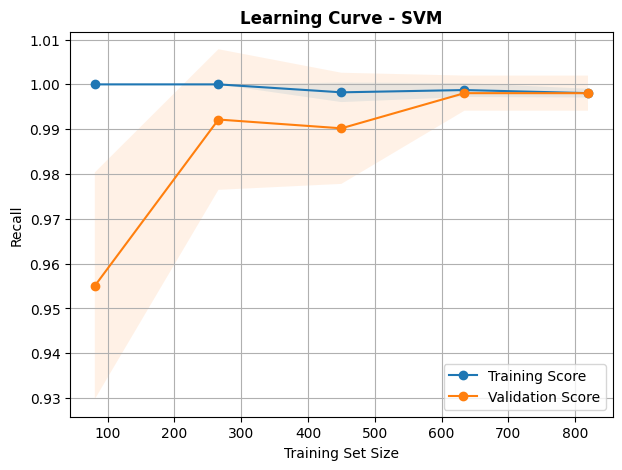


Plotting learning curve for Bagging (ANN)...


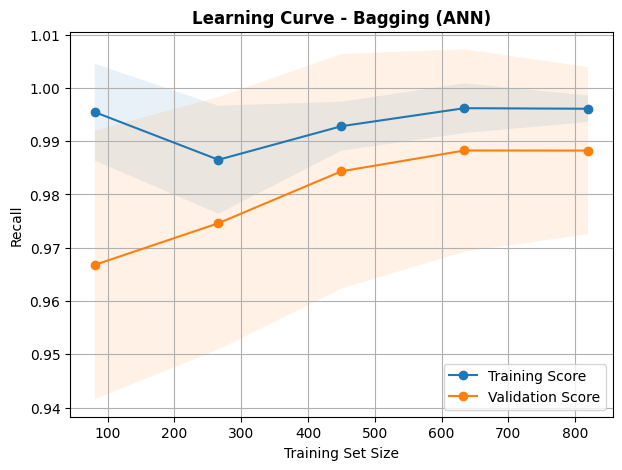


Plotting learning curve for Gradient Boosting...


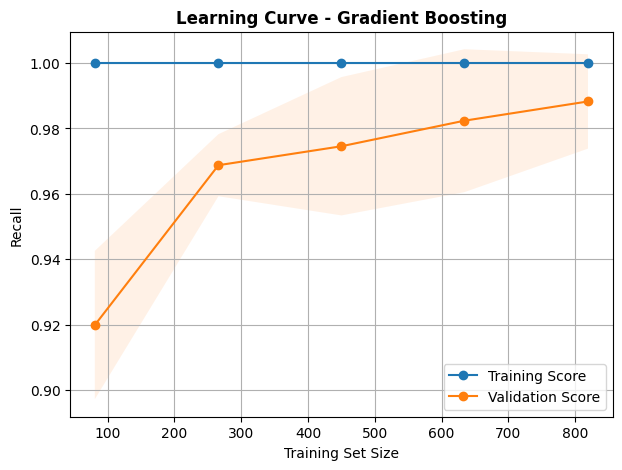


Plotting learning curve for Naive Bayes...


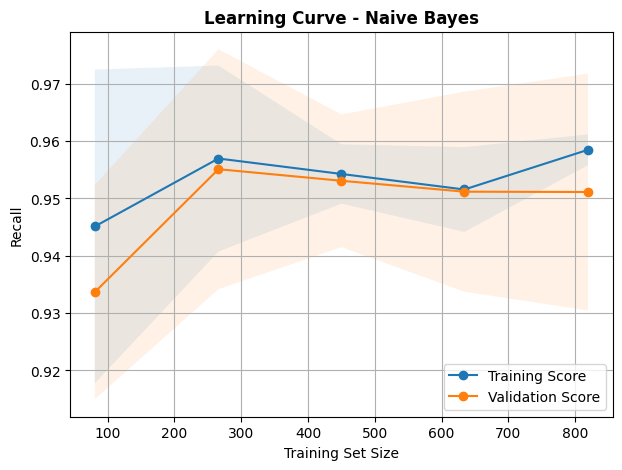


Plotting learning curve for ANN...


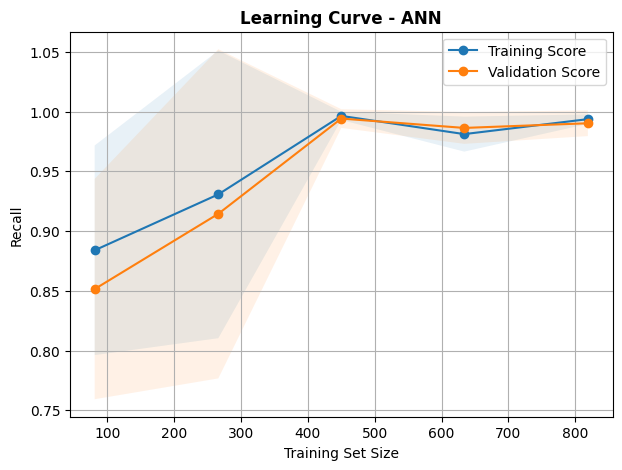

In [21]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Function to plot learning curve
# -------------------------------

def plot_learning_curve(model, model_name, X, y, scoring='accuracy'):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X, y,
        cv=5,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)

    val_mean = np.mean(val_scores, axis=1)
    val_std  = np.std(val_scores, axis=1)

    plt.figure(figsize=(7, 5))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation Score')

    plt.fill_between(train_sizes,
                     train_mean - train_std,
                     train_mean + train_std,
                     alpha=0.1)

    plt.fill_between(train_sizes,
                     val_mean - val_std,
                     val_mean + val_std,
                     alpha=0.1)

    plt.title(f'Learning Curve - {model_name}', fontsize=12, fontweight='bold')
    plt.xlabel('Training Set Size')
    plt.ylabel(scoring.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()


# ============================================
# SELECT TOP MODELS
# ============================================

# Choose top models based on Recall + ROC-AUC priority
top_models = results_df.sort_values(
    by=['Recall', 'ROC-AUC'], ascending=False
).head(5)['Model'].tolist()

print("\nTop models selected for learning curve analysis:")
print(top_models)


# ============================================
# PLOT LEARNING CURVES
# ============================================

for model_name in top_models:
    model = trained_models[model_name]

    print(f"\nPlotting learning curve for {model_name}...")

    plot_learning_curve(
        model,
        model_name,
        X_train_final,
        y_train_final,
        scoring='recall'   # medical priority metric
    )



Top 6 Models Selected for Loss Curve Analysis:
1. SVM
2. Bagging (ANN)
3. Gradient Boosting
4. Naive Bayes
5. ANN
6. XGBoost

Plotting loss curve for SVM...


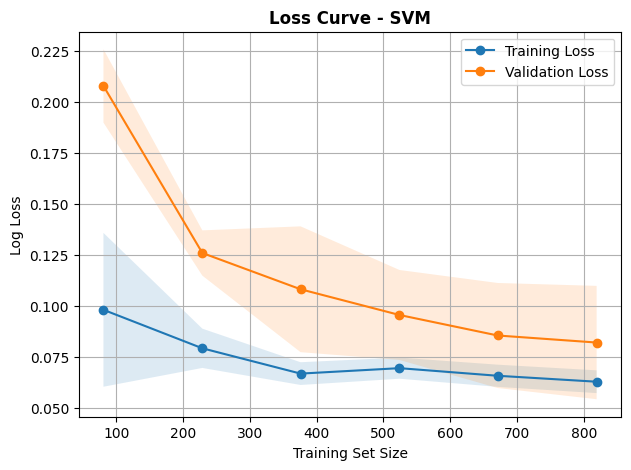


Plotting loss curve for Bagging (ANN)...


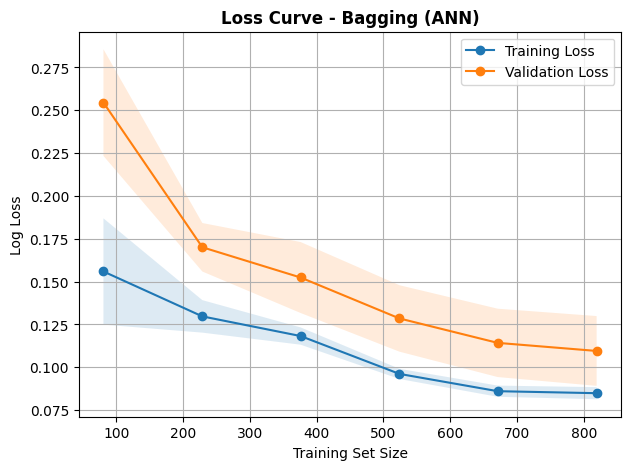


Plotting loss curve for Gradient Boosting...


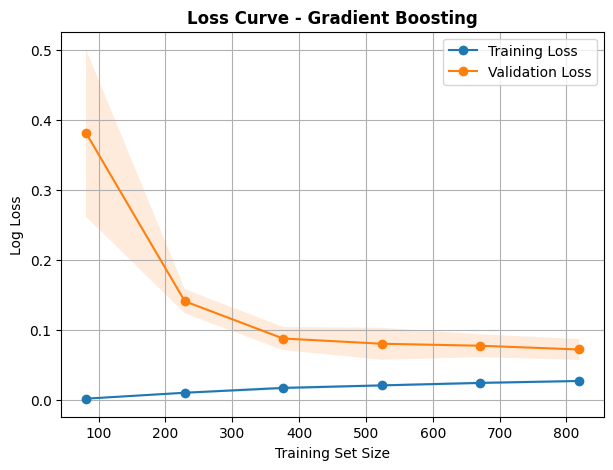


Plotting loss curve for Naive Bayes...


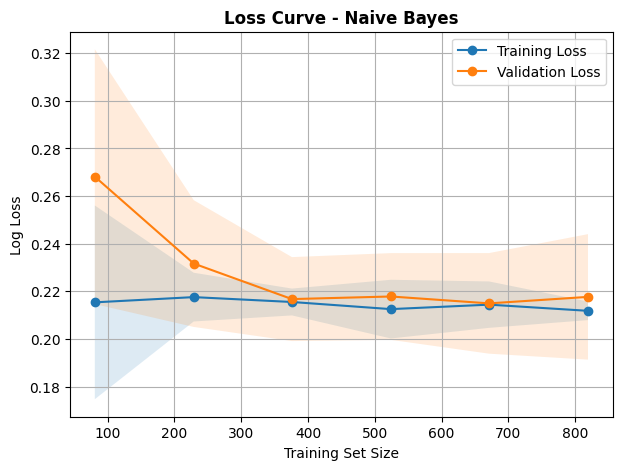


Plotting loss curve for ANN...


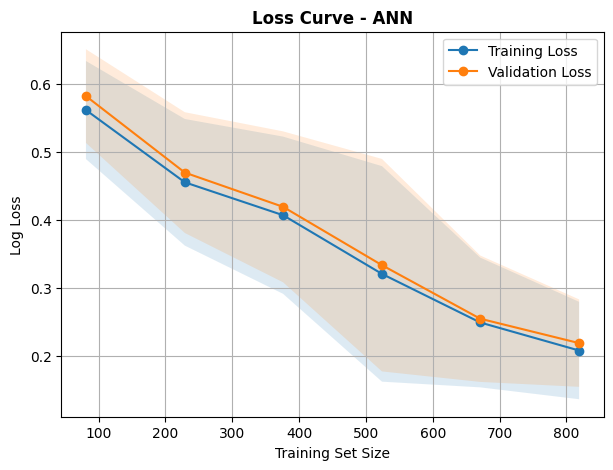


Plotting loss curve for XGBoost...


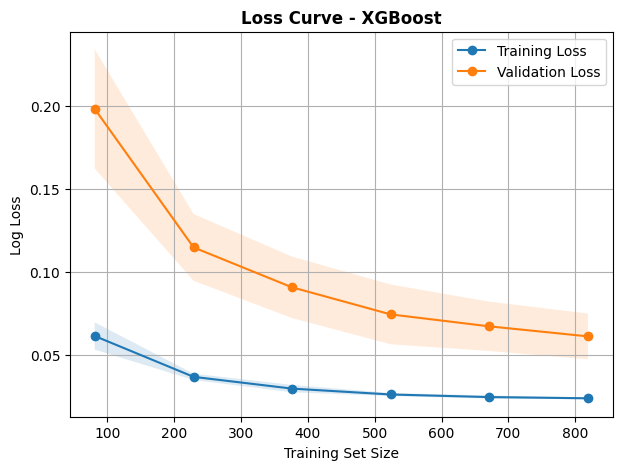

In [22]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Function to plot LOSS learning curves
# -------------------------------

def plot_loss_learning_curve(model, model_name, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X, y,
        cv=5,
        scoring='neg_log_loss',
        train_sizes=np.linspace(0.1, 1.0, 6),
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    # Convert negative log loss → positive loss
    train_loss = -np.mean(train_scores, axis=1)
    val_loss   = -np.mean(val_scores, axis=1)

    train_std = np.std(train_scores, axis=1)
    val_std   = np.std(val_scores, axis=1)

    plt.figure(figsize=(7, 5))
    plt.plot(train_sizes, train_loss, 'o-', label='Training Loss')
    plt.plot(train_sizes, val_loss, 'o-', label='Validation Loss')

    plt.fill_between(train_sizes,
                     train_loss - train_std,
                     train_loss + train_std,
                     alpha=0.15)

    plt.fill_between(train_sizes,
                     val_loss - val_std,
                     val_loss + val_std,
                     alpha=0.15)

    plt.title(f'Loss Curve - {model_name}', fontsize=12, fontweight='bold')
    plt.xlabel('Training Set Size')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


# ============================================
# SELECT TOP 6 MODELS (MEDICAL PRIORITY)
# ============================================

top_6_models = results_df.sort_values(
    by=['Recall', 'ROC-AUC'], ascending=False
).head(6)['Model'].tolist()

print("\nTop 6 Models Selected for Loss Curve Analysis:")
for i, m in enumerate(top_6_models, 1):
    print(f"{i}. {m}")


# ============================================
# PLOT LOSS CURVES
# ============================================

for model_name in top_6_models:
    model = trained_models[model_name]

    print(f"\nPlotting loss curve for {model_name}...")

    plot_loss_learning_curve(
        model,
        model_name,
        X_train_final,
        y_train_final
    )


In [23]:
# ============================================
# 8. BEST MODEL ANALYSIS AND DEPLOYMENT
# ============================================
print("\n" + "="*60)
print("8. BEST MODEL ANALYSIS & DEPLOYMENT")
print("="*60)

# --------------------------------------------
# SMART BEST MODEL SELECTION (Medical Priority)
# --------------------------------------------

# Selection priority:
# Recall -> F1-Score -> ROC-AUC -> Accuracy

best_row = results_df.sort_values(
    by=['Recall', 'F1-Score', 'ROC-AUC', 'Accuracy'],
    ascending=False
).iloc[0]

best_model_name = best_row['Model']
best_model = trained_models[best_model_name]

print(f"\nBest Model Selected: {best_model_name}")
print(f"Accuracy : {best_row['Accuracy']:.4f}")
print(f"Recall   : {best_row['Recall']:.4f}")
print(f"F1-Score : {best_row['F1-Score']:.4f}")
print(f"ROC-AUC  : {best_row['ROC-AUC']:.4f}")

# --------------------------------------------
# Cross Validation for Best Model
# --------------------------------------------

cv_scores = cross_val_score(
    best_model, X_train_scaled, y_train, cv=5, scoring='recall'
)

print(f"\nCross-Validation Results for {best_model_name}:")
print(f"Recall Scores: {cv_scores}")
print(f"Mean CV Recall: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# --------------------------------------------
# Feature Importance (If Available)
# --------------------------------------------

if hasattr(best_model, 'feature_importances_'):

    print("\n" + "-"*50)
    print("FEATURE IMPORTANCE (Best Model)")
    print("-"*50)

    importances = best_model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(feature_importance_df)

    plt.figure(figsize=(10, 6))
    plt.barh(
        feature_importance_df['Feature'],
        feature_importance_df['Importance']
    )
    plt.gca().invert_yaxis()
    plt.xlabel('Importance Score')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print(f"\n{best_model_name} does not provide native feature importance.")
    print("→ Consider SHAP or permutation importance for model explainability.")

# --------------------------------------------
# Save Final Model for Deployment
# --------------------------------------------

import joblib

joblib.dump(best_model, 'best_diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("\n✓ Best model and scaler successfully saved for deployment")

# --------------------------------------------
# Sample Inference Pipeline (Deployment Ready)
# --------------------------------------------

def predict_diabetes_risk(input_data):
    """
    input_data: array-like of shape (n_features,)
    returns: predicted class and probability
    """
    input_data = np.array(input_data).reshape(1, -1)
    input_scaled = scaler.transform(input_data)

    prediction = best_model.predict(input_scaled)[0]
    probability = best_model.predict_proba(input_scaled)[0][1]

    return prediction, probability


print("\n✓ Deployment inference function ready")



8. BEST MODEL ANALYSIS & DEPLOYMENT

Best Model Selected: SVM
Accuracy : 0.9860
Recall   : 0.9286
F1-Score : 0.9286
ROC-AUC  : 0.9972

Cross-Validation Results for SVM:
Recall Scores: [0.72727273 0.36363636 0.5        0.66666667 0.5       ]
Mean CV Recall: 0.5515 (+/- 0.2604)

SVM does not provide native feature importance.
→ Consider SHAP or permutation importance for model explainability.

✓ Best model and scaler successfully saved for deployment

✓ Deployment inference function ready


In [24]:
# ============================================
# 9. PREDICTION FUNCTION WITH NEW FEATURES
# ============================================
print("\n" + "="*60)
print("9. PREDICTION FUNCTION")
print("="*60)

def predict_diabetes_risk(bmi, blood_glucose, physical_activity,
                         diet, medication_adherence, stress_level,
                         sleep_hours, hydration_level):
    """
    Predict diabetes risk using optimized feature set
    Note: weight and height removed to avoid multicollinearity with BMI
    """
    # Prepare input array in the correct order
    input_data = np.array([[
        blood_glucose, physical_activity, diet,
        medication_adherence, stress_level, sleep_hours,
        hydration_level, bmi
    ]])

    # Scale input
    input_scaled = scaler.transform(input_data)

    # Get prediction
    prediction = best_model.predict(input_scaled)[0]
    probability = best_model.predict_proba(input_scaled)[0]

    risk_level = "Low Risk" if prediction == 0 else "High Risk"
    confidence = probability[prediction]

    # Get feature importance if available
    feature_contributions = {}
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        for i, feature in enumerate(feature_names):
            feature_contributions[feature] = {
                'value': input_data[0, i],
                'importance': importances[i]
            }

    return {
        'risk_prediction': risk_level,
        'confidence': float(confidence),
        'low_risk_probability': float(probability[0]),
        'high_risk_probability': float(probability[1]),
        'feature_contributions': feature_contributions if feature_contributions else None
    }

# Example usage
print("\nExample Prediction (using optimized features):")
example_result = predict_diabetes_risk(
    bmi=27.5,
    blood_glucose=145,
    physical_activity=25.5,
    diet=1,
    medication_adherence=1,
    stress_level=2,
    sleep_hours=6.5,
    hydration_level=1
)

print("\nPrediction Result:")
for key, value in example_result.items():
    if key != 'feature_contributions':
        print(f"{key.replace('_', ' ').title()}: {value}")

# Visualize prediction with feature contributions
if example_result['feature_contributions']:
    print("\n" + "-"*40)
    print("FEATURE CONTRIBUTIONS TO PREDICTION")
    print("-"*40)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Bar chart of feature values vs normal ranges
    axes[0].set_title('Patient Values vs Normal Ranges', fontsize=12, fontweight='bold')

    # Normal ranges for features (example values)
    normal_ranges = {
        'bmi': (18.5, 24.9),
        'blood_glucose': (70, 140),
        'physical_activity': (30, 60),
        'sleep_hours': (7, 9)
    }

    for i, (feature, data) in enumerate(example_result['feature_contributions'].items()):
        if feature in normal_ranges:
            low, high = normal_ranges[feature]
            axes[0].plot([low, high], [i, i], 'g-', linewidth=4, label='Normal Range' if i==0 else "")
            axes[0].plot(data['value'], i, 'ro', markersize=10, label='Patient Value' if i==0 else "")

    axes[0].set_yticks(range(len(example_result['feature_contributions'])))
    axes[0].set_yticklabels(list(example_result['feature_contributions'].keys()))
    axes[0].set_xlabel('Value')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Feature importance in prediction
    axes[1].set_title('Feature Importance in Current Prediction', fontsize=12, fontweight='bold')
    features = list(example_result['feature_contributions'].keys())
    importances = [data['importance'] for data in example_result['feature_contributions'].values()]

    bars = axes[1].barh(features, importances, color='lightblue', edgecolor='black')
    axes[1].set_xlabel('Importance Score')
    axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("ML PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"\nKey Improvements:")
print(f"1. Removed weight and height (redundant with BMI)")
print(f"2. Reduced multicollinearity")
print(f"3. Used 8 optimized features instead of 10")
print(f"4. Best Model: {best_model_name}")
print(f"5. Test Accuracy: {results_df.loc[results_df['Accuracy'].idxmax(), 'Accuracy']:.4f}")
print("\nModels available for use:")
for name in trained_models.keys():
    print(f"  - {name}")
print("="*60)


9. PREDICTION FUNCTION

Example Prediction (using optimized features):

Prediction Result:
Risk Prediction: Low Risk
Confidence: 0.9999939033336388
Low Risk Probability: 0.9999939033336388
High Risk Probability: 6.096666361245131e-06

ML PIPELINE COMPLETED SUCCESSFULLY!

Key Improvements:
1. Removed weight and height (redundant with BMI)
2. Reduced multicollinearity
3. Used 8 optimized features instead of 10
4. Best Model: SVM
5. Test Accuracy: 0.9860

Models available for use:
  - Logistic Regression
  - Decision Tree
  - SVM
  - KNN
  - Naive Bayes
  - ANN
  - Random Forest
  - Bagging (ANN)
  - Gradient Boosting
  - XGBoost
  - Stacking (ANN Meta-Learner)
